<a href="https://colab.research.google.com/github/mpbeck/ANS-128-GP-The-Explorers-/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Change runtime to R
system("git clone https://github.com/mpbeck/ANS-128-GP-The-Explorers-.git")

In [ ]:
library(tidyverse)
library(dplyr)
library(lubridate)
library(cluster)
data <- read.csv("/content/ANS-128-GP-The-Explorers-/Avian Influenza (HPAI).csv")
class(data)

[1] "data.frame"

In [ ]:
# Data cleaning & regression analysis
#summary(data$target_H5_HPAI)
data <- data %>%
  mutate(
    Common_Name = str_replace_all(Common_Name, " ", "_"),
    Locality = str_replace_all(Locality, " ", "_"),
    Species = as.factor(Common_Name),
    State = as.factor(State),
    County = as.factor(County),
    Locality = as.factor(Locality),
    target_H5_HPAI = as.factor(target_H5_HPAI),
    Year = as.integer(as.character(Year)),
    Month = as.integer(as.character(Month)),
    Day = as.integer(as.character(Day)),
    date = make_date(Year, Month, Day),
    day_of_year = yday(date) # Converted date to number of days in the given year
  )

#head(data[, c("Species", "State", "County", "Locality", "day_of_year", "target_H5_HPAI")])
summary(data[, c("Species", "State", "County", "Locality", "Year", "target_H5_HPAI")])

              Species            State          County    
 European_Robin   :  420   Connaught:2927   Dublin :5191  
 Black-headed_Gull:  332   Leinster :8405   Galway :2502  
 Rook             :  278   Munster  :4386   Kerry  :1408  
 Herring_Gull     :  276   Ulster   : 586   Wicklow:1390  
 Mute_Swan        :  273                    Cork   :1275  
 Hooded_Crow      :  271                    (Other):4409  
 (Other)          :14454                    NA's   : 129  
                            Locality          Year      target_H5_HPAI
 Rogerstown_Estuary--Turvey_Hide:  464   Min.   :1980   0:13719       
 East_Coast_NR                  :  438   1st Qu.:2016   1: 2585       
 Rogerstown_Estuary--North_Hide :  381   Median :2018                 
 St._Stephen's_Green            :  376   Mean   :2017                 
 Lough_Atalia                   :  331   3rd Qu.:2019                 
 Tacumshin_Lake--general_area   :  314   Max.   :2020                 
 (Other)                       

In [ ]:
num_species <- data %>%
  distinct(Common_Name) %>%
  nrow()
length(unique(data$Common_Name)) == num_species # 410 species
length(unique(data$State)) # 4 States
length(unique(data$County)) # 27 Counties
length(unique(data$Locality)) # 1288 Localities
length(unique(data$Year)) # 21 Years

model <- glm(target_H5_HPAI ~ 1 + Year + day_of_year + State + County, data = data, family = binomial)
summary(model) # 3 varibles ommited due to colinerality

[1] TRUE

[1] 4

[1] 27

[1] 1288

[1] 21


Call:
glm(formula = target_H5_HPAI ~ 1 + Year + day_of_year + State + 
    County, family = binomial, data = data)

Coefficients: (3 not defined because of singularities)
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -81.395933  20.283472  -4.013 6.00e-05 ***
Year              0.039593   0.010054   3.938 8.21e-05 ***
day_of_year       0.002007   0.000241   8.327  < 2e-16 ***
StateLeinster   -13.452991 244.425257  -0.055  0.95611    
StateMunster     -1.300761   0.309614  -4.201 2.65e-05 ***
StateUlster     -13.244853 214.053803  -0.062  0.95066    
CountyCavan      13.435037 214.054806   0.063  0.94995    
CountyClare       0.062663   0.242408   0.259  0.79602    
CountyCork        0.427239   0.229811   1.859  0.06301 .  
CountyDonegal    11.656853 214.053758   0.054  0.95657    
CountyDublin     13.372037 244.425157   0.055  0.95637    
CountyGalway     -0.512378   0.231345  -2.215  0.02678 *  
CountyKerry       0.332905   0.229865   1.448  0.14754    
Co

In [ ]:
table(data$County, data$target_H5_HPAI)

           
               0    1
  Carlow      13    0
  Cavan        7    3
  Clare      906   83
  Cork      1117  158
  Donegal    525   34
  Dublin    4015 1176
  Galway    2108  394
  Kerry     1254  154
  Kildare     59    3
  Kilkenny    84   10
  Laoighis     2    0
  Laois       10    0
  Leitrim      3    2
  Limerick   172   55
  Louth      236   64
  Mayo       213   31
  Meath      110    7
  Monaghan    17    0
  Offaly      60    5
  Roscommon   50   21
  Sligo       78   27
  Tipperary  169   18
  Waterford  270   24
  Westmeath   17    1
  Wexford    890  130
  Wicklow   1216  174

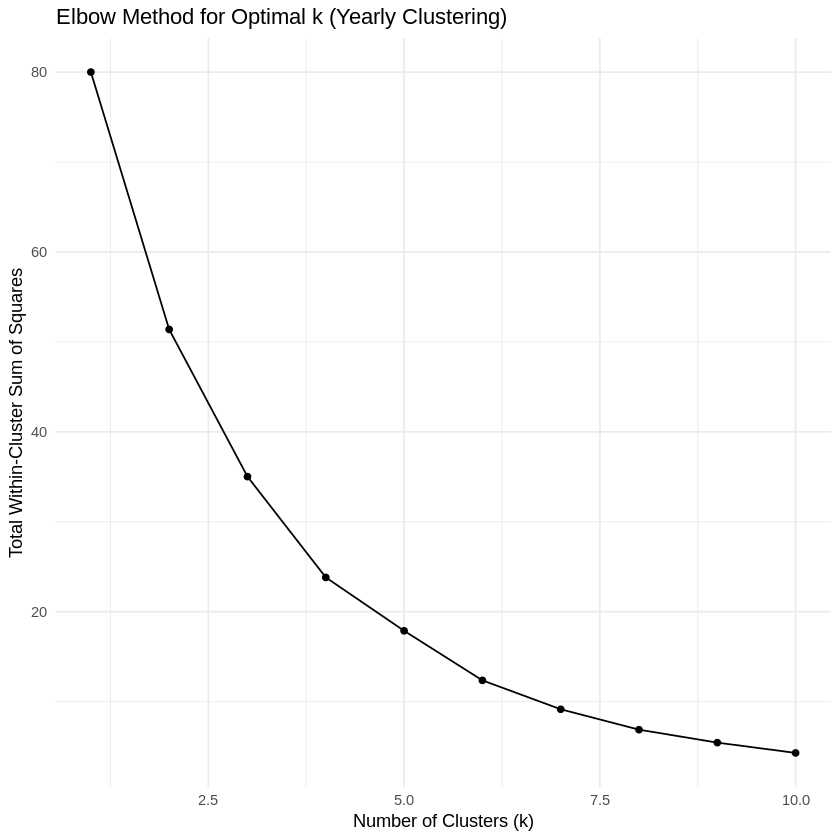

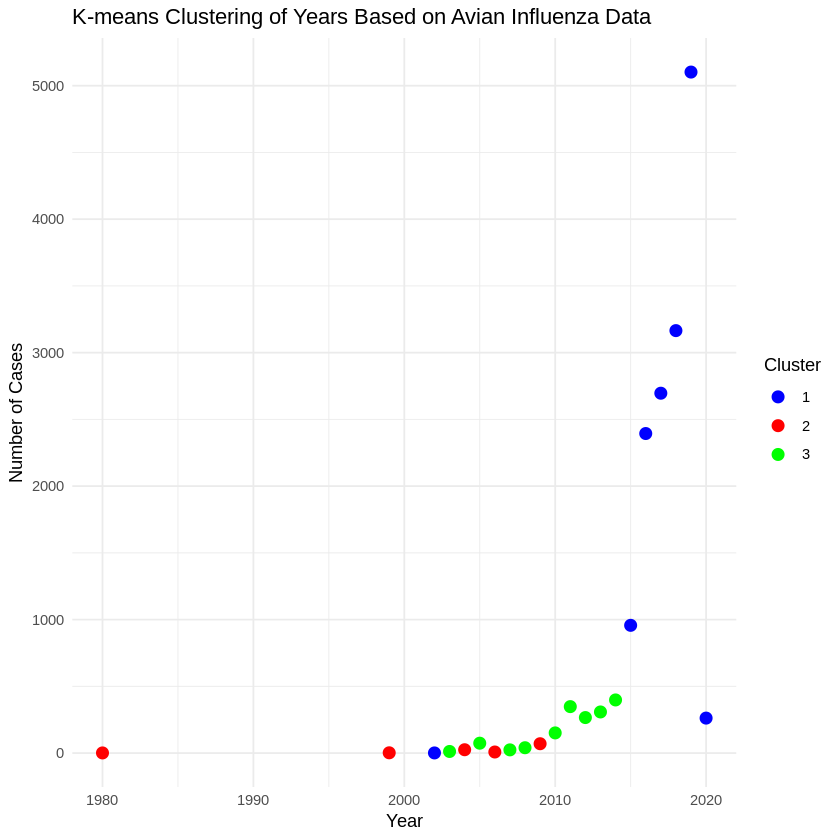

In [ ]:
# Clustering analysis
# Aggregate data by Year
data <- data %>%
  mutate(target_H5_HPAI = as.numeric(as.character(target_H5_HPAI)))

yearly_summary <- data %>%
  group_by(Year) %>%
  summarize(
    count_cases = n(),
    avg_latitude = mean(Latitude, na.rm = TRUE),
    avg_longitude = mean(Longitude, na.rm = TRUE),
    h5_hpai_mean = mean(target_H5_HPAI, na.rm = TRUE)
  )

# Standardize the features
features <- scale(yearly_summary[, c("count_cases", "avg_latitude", "avg_longitude", "h5_hpai_mean")])

# Determine optimal clusters using the Elbow Method
wss <- sapply(1:10, function(k) {
  kmeans(features, centers = k, nstart = 25)$tot.withinss
})

# Elbow Method Plot
elbow_plot <- data.frame(k = 1:10, wss = wss)
ggplot(elbow_plot, aes(x = k, y = wss)) +
  geom_point() +
  geom_line() +
  labs(title = "Elbow Method for Optimal k (Yearly Clustering)",
       x = "Number of Clusters (k)",
       y = "Total Within-Cluster Sum of Squares") +
  theme_minimal()
cat("\n")

# Apply K-means clustering with k=4
set.seed(128)
k <- 3
kmeans_model <- kmeans(features, centers = k, nstart = 25)

# Add cluster labels to the dataset
yearly_summary$Cluster <- as.factor(kmeans_model$cluster)

# Visualizing the clusters
ggplot(yearly_summary, aes(x = Year, y = count_cases, color = Cluster)) +
  geom_point(size = 3) +
  labs(title = "K-means Clustering of Years Based on Avian Influenza Data",
       x = "Year",
       y = "Number of Cases") +
  theme_minimal() +
  scale_color_manual(values = c("blue", "red", "green")) +
  theme(legend.position = "right")

In [ ]:
yearly_summary
#features

Year,count_cases,avg_latitude,avg_longitude,h5_hpai_mean,Cluster
<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
1980,1,52.69630,-8.815300,0.00000000,1
1999,2,51.63050,-8.547000,0.00000000,1
2002,1,53.18360,-6.186300,0.00000000,3
2003,12,52.84914,-8.017067,0.08333333,2
2004,25,52.69942,-8.745204,0.00000000,1
2005,74,52.95788,-8.341885,0.09459459,2
2006,8,52.38449,-8.797175,0.00000000,1
2007,24,52.88931,-8.939592,0.29166667,2
2008,40,53.25602,-8.126100,0.17500000,2
